In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_squared_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("viridis")

# Set random seed for reproducibility
np.random.seed(42)

# Define directory paths
data_dir = "../data"
output_dir = "../outputs"
model_dir = "../../ai/models/generated"

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

print("Risk Analysis Model Notebook Initialized")

Risk Analysis Model Notebook Initialized


In [7]:
def load_market_data():
    """
    Load and preprocess market data from NSE files
    """
    try:
        # Define all possible NSE file patterns to search for
        nse_file_patterns = [
            "NSE_data_all_stocks_*.csv",           # Main stock data files
            "../*/NSE_data_all_stocks_*.csv",      # Check parent directories
            "../../*/NSE_data_all_stocks_*.csv",   # Check grandparent directories
        ]
        
        # Find all matching files
        import glob
        file_paths = []
        for pattern in nse_file_patterns:
            file_paths.extend(glob.glob(pattern))
        
        if not file_paths:
            print("No NSE stock data files found using patterns. Checking for specific year files...")
            # Try specific year files as fallback
            for year in range(2013, 2025):
                specific_file = f"NSE_data_all_stocks_{year}.csv"
                if os.path.exists(specific_file):
                    file_paths.append(specific_file)
        
        if not file_paths:
            print("No NSE stock data files found. Using synthetic market data.")
            return None
        
        print(f"Found {len(file_paths)} NSE data files: {file_paths}")
        
        # Combine all stock data files
        dfs = []
        for file_path in file_paths:
            df = pd.read_csv(file_path)
            # Extract year from filename for reference
            import re
            year_match = re.search(r'(\d{4})', os.path.basename(file_path))
            year = year_match.group(1) if year_match else "unknown"
            print(f"Loading NSE data from {file_path} (Year: {year}) with {len(df)} records")
            
            # Standardize column names
            df.columns = [col.lower().replace(' ', '_') for col in df.columns]
            
            # Add year column if not present
            if 'year' not in df.columns:
                df['year'] = year
                
            dfs.append(df)
        
        combined_df = pd.concat(dfs, ignore_index=True)
        
        # Convert date to datetime
        date_col = 'date' if 'date' in combined_df.columns else 'date'
        combined_df[date_col] = pd.to_datetime(combined_df[date_col], errors='coerce')
        
        # Convert numeric columns to float
        price_cols = [col for col in combined_df.columns if any(
            x in col.lower() for x in ['price', 'low', 'high', 'change', 'previous', 'volume'])]
        for col in price_cols:
            if col in combined_df.columns:
                combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
        
        print(f"Successfully loaded market data with {len(combined_df)} records across {len(file_paths)} files.")
        
        # Perform basic data validation
        missing_date = combined_df[combined_df[date_col].isna()].shape[0]
        if missing_date > 0:
            print(f"Warning: {missing_date} records have missing dates ({missing_date/len(combined_df):.2%})")
        
        # Print date range
        date_min = combined_df[date_col].min()
        date_max = combined_df[date_col].max()
        print(f"Data spans from {date_min} to {date_max}")
        
        # Print summary of key columns
        print("\nMarket Data Summary:")
        summary_cols = ['day_price', 'volume', 'change%'] if 'change%' in combined_df.columns else ['day_price', 'volume']
        print(combined_df[summary_cols].describe().round(2))
        
        return combined_df
    
    except Exception as e:
        print(f"Error loading market data: {e}")
        import traceback
        traceback.print_exc()
        return None

def generate_synthetic_user_data(num_samples=1000):
    """
    Generate synthetic user financial data for model development
    """
    np.random.seed(42)
    
    # User IDs
    user_ids = np.arange(1000, 1000 + num_samples)
    
    # Income (monthly in KES)
    income = np.random.lognormal(mean=11.5, sigma=0.7, size=num_samples)  # centered around ~100k KES
    
    # Expenses (as percentage of income)
    expense_ratio = np.random.normal(0.7, 0.15, num_samples)
    expense_ratio = np.clip(expense_ratio, 0.2, 1.2)  # clip values
    expenses = income * expense_ratio
    
    # Debt
    has_debt = np.random.choice([0, 1], size=num_samples, p=[0.3, 0.7])
    debt_amount = np.zeros(num_samples)
    debt_amount[has_debt == 1] = np.random.lognormal(mean=11.0, sigma=1.0, size=np.sum(has_debt == 1))
    
    # Debt-to-Income Ratio
    dti_ratio = debt_amount / (income * 12)  # Annual debt to income
    
    # Savings
    savings_rate = np.random.normal(0.1, 0.07, num_samples)
    savings_rate = np.clip(savings_rate, 0, 0.4)
    savings = income * savings_rate * np.random.randint(1, 60, num_samples)  # Random months of savings
    
    # Assets
    asset_value = savings * np.random.uniform(1, 5, num_samples) + np.random.lognormal(mean=12, sigma=1.5, size=num_samples) * np.random.binomial(1, 0.4, num_samples)
    
    # Credit Score (300-850)
    credit_score = np.random.normal(650, 100, num_samples).astype(int)
    credit_score = np.clip(credit_score, 300, 850)
    
    # Risk Tolerance (1-10)
    risk_tolerance = np.random.randint(1, 11, num_samples)
    
    # Investment Experience (years)
    investment_experience = np.random.exponential(3, num_samples)
    investment_experience = np.clip(investment_experience, 0, 25)
    
    # Age
    age = np.random.normal(35, 10, num_samples).astype(int)
    age = np.clip(age, 18, 75)
    
    # Employment Status
    employment_status = np.random.choice(
        ['Employed', 'Self-Employed', 'Unemployed', 'Student', 'Retired'],
        size=num_samples,
        p=[0.65, 0.2, 0.05, 0.05, 0.05]
    )
    
    # Education Level
    education_level = np.random.choice(
        ['High School', 'College', 'Bachelor', 'Master', 'PhD'],
        size=num_samples,
        p=[0.15, 0.25, 0.4, 0.15, 0.05]
    )
    
    # Financial Goals
    financial_goals = np.random.choice(
        ['Retirement', 'Home Purchase', 'Education', 'Emergency Fund', 'Wealth Building'],
        size=num_samples
    )
    
    # Historical Payment Behavior (0-1, higher is better)
    payment_behavior = np.random.beta(5, 2, num_samples)
    
    # Loan Default History (binary: 0 = no default, 1 = has defaulted)
    default_history = np.random.binomial(1, 0.1, num_samples)
    
    # Target Variables
    # 1. Risk Score (1-10)
    # Factors: DTI, payment history, default history, credit score, income stability
    risk_components = [
        (dti_ratio * 10) / 2,  # DTI component (higher is riskier)
        (1 - payment_behavior) * 5,  # Payment behavior component
        default_history * 3,  # Default history component
        (850 - credit_score) / 85,  # Credit score component
        (np.random.normal(0, 1, num_samples) + 2) * np.random.binomial(1, 0.2, num_samples)  # Random risk factors
    ]
    
    risk_score = np.sum(risk_components, axis=0) / len(risk_components) * 2
    risk_score = np.clip(risk_score, 1, 10).round(1)
    
    # 2. Investment Growth Potential (%)
    # Factors: risk tolerance, investment experience, market conditions, asset allocation
    base_growth = np.random.normal(0.07, 0.03, num_samples)  # Base growth around 7%
    risk_adjustment = (risk_tolerance - 5.5) * 0.01  # Higher risk can mean higher growth
    experience_factor = np.minimum(investment_experience * 0.005, 0.05)  # Experience helps, up to a point
    
    investment_growth = (base_growth + risk_adjustment + experience_factor) * 100  # Convert to percentage
    investment_growth = np.clip(investment_growth, -5, 25).round(2)
    
    # 3. Loan Default Probability (0-1)
    # Factors: DTI, payment history, credit score, income
    default_components = [
        dti_ratio * 0.4,  # DTI component
        (1 - payment_behavior) * 0.3,  # Payment behavior component
        ((850 - credit_score) / 850) * 0.2,  # Credit score component
        (1 - (np.log(income) - 9) / 4) * 0.1  # Income component (higher income = lower default)
    ]
    
    loan_default_prob = np.sum(default_components, axis=0)
    loan_default_prob = np.clip(loan_default_prob, 0.01, 0.99).round(3)
    
    # Create DataFrame
    user_data = pd.DataFrame({
        'user_id': user_ids,
        'age': age,
        'income_monthly': income.round(2),
        'expenses_monthly': expenses.round(2),
        'debt_amount': debt_amount.round(2),
        'dti_ratio': dti_ratio.round(3),
        'savings': savings.round(2),
        'asset_value': asset_value.round(2),
        'credit_score': credit_score,
        'risk_tolerance': risk_tolerance,
        'investment_experience': investment_experience.round(1),
        'employment_status': employment_status,
        'education_level': education_level,
        'financial_goal': financial_goals,
        'payment_behavior': payment_behavior.round(3),
        'default_history': default_history,
        'risk_score': risk_score,
        'investment_growth_potential': investment_growth,
        'loan_default_probability': loan_default_prob
    })
    
    print(f"Generated synthetic data for {num_samples} users.")
    return user_data

# Load market data - prioritize actual NSE data
print("\n==== Loading Actual Market Data ====")
market_data = load_market_data()

# Generate synthetic user data
print("\n==== Generating User Data ====")
user_data = generate_synthetic_user_data(2000)

# Save synthetic data for later use
user_data.to_csv(os.path.join(data_dir, "synthetic_user_financial_data.csv"), index=False)

# Display summary statistics
print("\nUser Data Summary Statistics:")
print(user_data.describe().round(2))


==== Loading Actual Market Data ====
No NSE stock data files found using patterns. Checking for specific year files...
No NSE stock data files found. Using synthetic market data.

==== Generating User Data ====
Generated synthetic data for 2000 users.

User Data Summary Statistics:
       user_id      age  income_monthly  expenses_monthly  debt_amount  \
count  2000.00  2000.00         2000.00           2000.00      2000.00   
mean   1999.50    35.05       129710.54          90385.11     68635.97   
std     577.49     9.49       103813.21          75419.34    123511.22   
min    1000.00    18.00        10209.90           6720.09         0.00   
25%    1499.75    28.00        63840.09          42225.46         0.00   
50%    1999.50    35.00       101852.84          69892.50     30994.32   
75%    2499.25    42.00       159226.84         112615.20     80974.96   
max    2999.00    66.00      1464335.40        1024879.13   2041213.80   

       dti_ratio     savings  asset_value  credit


Analyzing SCOM

Analyzing EQTY

Analyzing KCB

Analyzing COOP

Analyzing EABL


Investment Recommendations Summary:
  Stock Code Stock Name  Current Price  Forecast Price  Change (%)  \
0       SCOM       SCOM          122.5      126.582565    3.332706   
1       EQTY       EQTY          122.5      126.582565    3.332706   
2        KCB        KCB          122.5      126.582565    3.332706   
3       COOP       COOP          122.5      126.582565    3.332706   
4       EABL       EABL          122.5      126.582565    3.332706   

  Recommendation Confidence  Trend (%)  
0       HOLD/BUY        Low  -0.098449  
1       HOLD/BUY        Low  -0.098449  
2       HOLD/BUY        Low  -0.098449  
3       HOLD/BUY        Low  -0.098449  
4       HOLD/BUY        Low  -0.098449  


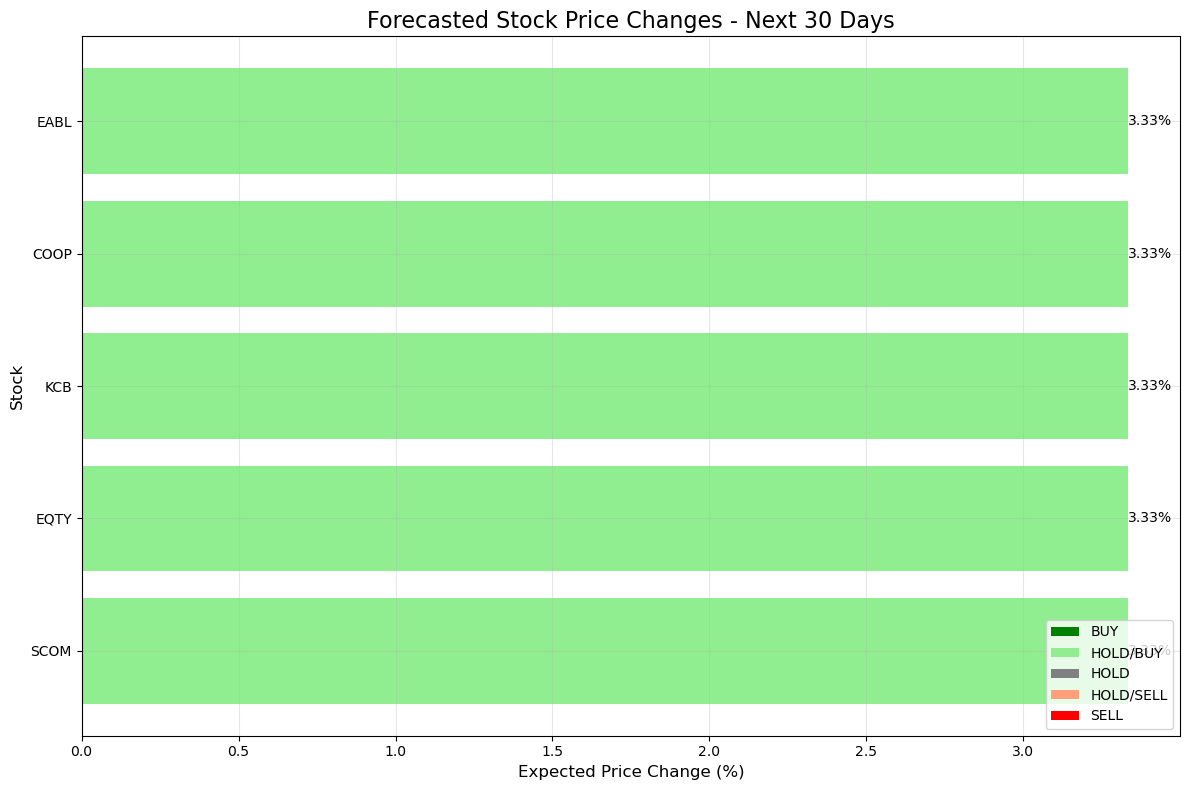